# Portfolio

This is the last step of our work, where we will be creating a porfolio that contains the predictions of the best stocks to invest in daily, and then we will optimize it. Our objective with the optimization is to minimize maximum risk, while also maximizing minimum return!<br>

Real life investments will be simulated according to the work guidelines.<br>
We will have an **initial budget of 10,000 USD**, which we plan to invest daily. This will be done by buying a maximum of **100 stocks per day** (with an **operation cost of 1 USD**), while never exceding the budget. 

Our results will be evaluated using financial metrics such as the cumulative return!

This notebook is divided the following way:
- 0. Libraries
- 1. Price Predictions
- 2. Stock Choice Algorithm (Monte Carlo)
- 3. Simulations
- 4. Results

# 

# 0. Libraries

In [1]:
import os
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import joblib

# 

# 1. Price Predictions

The first thing we need to do is get the predictions for each day of the month!<br>
We will create a dictionary that, for each day of January 2024 holds the Close price of the day, and the prediction of the Close price for the next day.<br>
This way, we simulate daily investments, without ever leaking data from future days!

This process will be done 2 different times, since we decided to test results for different prediction models.<br>
As such, we will obtain a dictionary for **Random Forest** predictions and a dictionary for **MultiLayer Perceptron** predictions.

In [2]:
#open the original features (for price reference!)
with open(os.path.join(os.getcwd(), "features/features_raw.pkl"), "rb") as ficheiro:
    features_raw = pickle.load(ficheiro)
ficheiro.close()
features_raw.fillna(0, inplace=True)
features_raw = features_raw[features_raw["Year"]==2024]

In [3]:
#open the processed features (for predictions!)
with open(os.path.join(os.getcwd(), "features/features_processed.pkl"), "rb") as ficheiro:
    features_normalized = pickle.load(ficheiro)
ficheiro.close()
features_normalized = features_normalized[features_normalized["Year"]==1]

In [4]:
#list all days from January (excluding 31, which we will predict on day 30)
dias_31 = features_normalized['Day'].unique()
dias_30 = np.delete(dias_31, 20)

In [5]:
#get all tickers names and codes on a dataframe
tickers = features_normalized['Ticker_code'].unique()
tickers_names = features_raw['Ticker'].unique()
tickers_df = pd.DataFrame({
    'Code':tickers,
    'Name': tickers_names
})

In [6]:
#for rf
rf = joblib.load('models/rf_model.joblib')

#dictionary that saves all the data from each day
dados_dos_dias_rf = {}

#for each day
for i in range(len(dias_30)):
    
    #create dataframe with features from current day
    daily_features_today_raw = features_raw[features_raw['Day']==dias_30[i]]
    daily_features_today_normalized = features_normalized[features_normalized['Day']==dias_30[i]]
    
    #create dataframe with features from next day
    daily_features_tomorrow_raw = features_raw[features_raw['Day']==dias_31[i+1]]
    daily_features_tomorrow_normalized = features_normalized[features_normalized['Day']==dias_31[i+1]]
    
    #create list to save the data from the current day
    dados_do_dia = []
    
    #for every existing stock
    for ticker in tickers:
        
        #create dataframe with features from current ticker current day 
        stock_features_today_raw = daily_features_today_raw[daily_features_today_raw['Ticker_code']==ticker]
        stock_features_today_normalized = daily_features_today_normalized[daily_features_today_normalized['Ticker_code']==ticker]
        
        #create dataframe with features from current ticker next day
        stock_features_tomorrow_raw = daily_features_tomorrow_raw[daily_features_tomorrow_raw['Ticker_code']==ticker]
        stock_features_tomorrow_normalized = daily_features_tomorrow_normalized[daily_features_tomorrow_normalized['Ticker_code']==ticker]        
        
        #extract features (volatility, close, close_next_day, prediction)
        volatility_5_raw = stock_features_today_raw['Volatility_5'].iloc[0]
        close_raw = stock_features_today_raw["Close"].iloc[0]
        close_normalized = stock_features_today_normalized["Close"].iloc[0]
        close_next_day_raw = stock_features_tomorrow_raw["Close"].iloc[0]
        close_next_day_raw_prediction = rf.predict(stock_features_today_normalized.drop(columns="Next_day_close"))[0]
        temp_ticker = tickers_df[tickers_df['Code']==ticker]
        
        #add features from current ticket to the list of current day data 
        #(day, ticker_name, ticker_code, volatility, close, close_next_day, prediction)
        dados_do_dia.append({
            'Dia': dias_30[i],
            'Ticker_name': temp_ticker.iloc[0,1],
            'Ticker_code': ticker,
            'Volatility_5_raw': volatility_5_raw,
            'Close_raw': close_raw,
            'Close_normalized': close_normalized,
            'Close_next_day_raw': close_next_day_raw,
            'Close_next_day_raw_prediction': close_next_day_raw_prediction
        })
    
    #add current day data do the dictionary of all data
    dados_dos_dias_rf[i] = pd.DataFrame(dados_do_dia)

In [7]:
dados_dos_dias_rf[0]

,Dia,Ticker_name,Ticker_code,Volatility_5_raw,Close_raw,Close_normalized,Close_next_day_raw,Close_next_day_raw_prediction
0,2,MMM,0,0.611485,88.892044,0.011959,87.106117,88.956876
1,2,AOS,1,0.384153,80.145653,0.010780,77.459038,80.260498
2,2,ABT,2,0.420923,107.700714,0.014496,107.377174,107.749732
3,2,ABBV,3,2.167446,154.183792,0.020764,154.801224,154.607655
4,2,ACN,4,2.708811,341.431366,0.046014,332.573761,341.710891
...,...,...,...,...,...,...,...,...
492,2,XYL,496,0.384725,112.429237,0.015133,110.342270,112.758988
493,2,YUM,497,0.706510,126.512314,0.017032,126.580956,126.537842
494,2,ZBRA,498,3.283494,267.980011,0.036109,252.520004,267.624457
495,2,ZBH,499,0.223152,120.625359,0.016239,119.711151,120.567358


In [8]:
#for mlp
mlp = joblib.load('models/mlp_model.joblib')

#dictionary that saves all the data from each day
dados_dos_dias_mlp = {}

#for each day
for i in range(len(dias_30)):
    
    #create dataframe with features from current day
    daily_features_today_raw = features_raw[features_raw['Day']==dias_30[i]]
    daily_features_today_normalized = features_normalized[features_normalized['Day']==dias_30[i]]
    
    #create dataframe with features from next day
    daily_features_tomorrow_raw = features_raw[features_raw['Day']==dias_31[i+1]]
    daily_features_tomorrow_normalized = features_normalized[features_normalized['Day']==dias_31[i+1]]
    
    #create list to save the data from the current day
    dados_do_dia = []
    
    #for every existing stock
    for ticker in tickers:
        
        #create dataframe with features from current ticker current day 
        stock_features_today_raw = daily_features_today_raw[daily_features_today_raw['Ticker_code']==ticker]
        stock_features_today_normalized = daily_features_today_normalized[daily_features_today_normalized['Ticker_code']==ticker]
        
        #create dataframe with features from current ticker next day
        stock_features_tomorrow_raw = daily_features_tomorrow_raw[daily_features_tomorrow_raw['Ticker_code']==ticker]
        stock_features_tomorrow_normalized = daily_features_tomorrow_normalized[daily_features_tomorrow_normalized['Ticker_code']==ticker]        
        
        #extract features (volatility, close, close_next_day, prediction)
        volatility_5_raw = stock_features_today_raw['Volatility_5'].iloc[0]
        close_raw = stock_features_today_raw["Close"].iloc[0]
        close_normalized = stock_features_today_normalized["Close"].iloc[0]
        close_next_day_raw = stock_features_tomorrow_raw["Close"].iloc[0]
        close_next_day_raw_prediction = mlp.predict(stock_features_today_normalized.drop(columns="Next_day_close"))[0]
        temp_ticker = tickers_df[tickers_df['Code']==ticker]
        
        #add features from current ticket to the list of current day data 
        #(day, ticker_name, ticker_code, volatility, close, close_next_day, prediction)
        dados_do_dia.append({
            'Dia': dias_30[i],
            'Ticker_name': temp_ticker.iloc[0,1],
            'Ticker_code': ticker,
            'Volatility_5_raw': volatility_5_raw,
            'Close_raw': close_raw,
            'Close_normalized': close_normalized,
            'Close_next_day_raw': close_next_day_raw,
            'Close_next_day_raw_prediction': close_next_day_raw_prediction
        })
    
    #add current day data do the dictionary of all data
    dados_dos_dias_mlp[i] = pd.DataFrame(dados_do_dia)

In [9]:
dados_dos_dias_mlp[0]

,Dia,Ticker_name,Ticker_code,Volatility_5_raw,Close_raw,Close_normalized,Close_next_day_raw,Close_next_day_raw_prediction
0,2,MMM,0,0.611485,88.892044,0.011959,87.106117,90.247972
1,2,AOS,1,0.384153,80.145653,0.010780,77.459038,81.345149
2,2,ABT,2,0.420923,107.700714,0.014496,107.377174,109.320116
3,2,ABBV,3,2.167446,154.183792,0.020764,154.801224,153.733027
4,2,ACN,4,2.708811,341.431366,0.046014,332.573761,349.390475
...,...,...,...,...,...,...,...,...
492,2,XYL,496,0.384725,112.429237,0.015133,110.342270,115.152622
493,2,YUM,497,0.706510,126.512314,0.017032,126.580956,129.850404
494,2,ZBRA,498,3.283494,267.980011,0.036109,252.520004,271.841518
495,2,ZBH,499,0.223152,120.625359,0.016239,119.711151,123.410953


# 

# 2. Stock Choice Algorithm (Monte Carlo)

We will now implement the algorithm that will decide which are the best stocks to invest in daily. We will achieve this through a Monte Carlo algorithm.<br>
For each day, our algorithm behaves the following way:

* **1** - Select the stocks that are expected to profit the next day. This is done by subtracting the prediction of the next day's price to the current day close price. The stocks where this value is bigger than the sum of half of our model RMSE, plus the transaction cost, will be selected.<br>In a more comprehensive manner:<br>**Valid stock =  (predicted_price - current_price) > ((RMSE/2) + transaction_cost)**.<br>Not only does this account for transaction costs, it also expects the model prediction to be off according to the RMSE!


* **2** - If there are at leat 2 valid stocks, randomly pick an amount of each selected stock (between 0 and max_transaction/selected_stocks), so that the total amount of bought stocks does not surpass the maximum amount of transactions.<br>Then it calculates the cost of the investment that was just done. If it surpasses the budget we currently have, another investment setup is done until it is totally valid.


* **3** - Now with an investment plan for the current day that abides to every established "law", we calculate the score of that plan. This score has the objective of minimizing the risk (picking a plan with low volatility) and maximizing profit (picking a plan with high profit).<br>This score is obtained by dividing the expected profit by the total volatility.<br>In a more comprehensive manner:<br>**Score = expected_profit / total_volatility**.<br>If the score for the plan is bigger than the currently tracked best score, then update the best plan to be the current plan!


* **4** . Restart from point 2 until the desired number of simulations has been done! When finished, return the best results!

In [10]:
#transaction info (cost, max)
transaction_cost = 1
max_transactions = 100

In [11]:
#monte carlo simulations for a single day
def monte_carlo_stock_selection(data, budget):
    
    #stocks of the day
    day_stocks = data.copy()
    
    #add predicted profit column
    day_stocks["Predicted_profit"] = day_stocks["Close_next_day_raw_prediction"] - day_stocks["Close_raw"]
    
    #dataframe with the stocks that are predicted to have real profit 
    stocks_to_buy = day_stocks[day_stocks["Predicted_profit"]>(rmse/2)+transaction_cost]
    
    #number of stocks with real predicted profit
    num_stocks = len(stocks_to_buy)

    #start best portfolio
    best_portfolio = np.zeros(num_stocks)
    best_score = 0
    expected_profit = 0
    actual_profit = 0
    buy_codes_final = []
    buy_names_final = []
    buy_quantity_final = []
    
    #if there are at least 2 stocks with real expected profit, do monte carlo!
    if len(stocks_to_buy)>1:
        
        #do simulations!
        for sim in range(num_simulations):
            
            #get current prices, predicted prices, real prices and volatilities
            current_prices = stocks_to_buy["Close_raw"].tolist()
            predicted_prices = stocks_to_buy["Close_next_day_raw_prediction"].tolist()
            real_prices = stocks_to_buy["Close_next_day_raw"].tolist()
            volatilities = stocks_to_buy["Volatility_5_raw"].tolist()
            
            #start lists for the bought stocks
            buy_codes = []
            buy_names = []
            buy_quantity = []
     
            #randomize a portfolio, assuring the total bought stocks dont surpass the max transactions, and at least 2 different stocks are bought!
            portfolio = [np.random.randint(0, max_transactions/len(stocks_to_buy)) for _ in range(len(stocks_to_buy))]
            current_transactions = np.sum(portfolio)
            while current_transactions>max_transactions:
                idx = np.random.randint(0, len(stocks_to_buy) - 1)
                if portfolio[idx]>0:
                    portfolio[idx] -= 1
                current_transactions = np.sum(portfolio)
                    
            #set total cost, expected profit and actual profit
            total_cost = np.sum(portfolio)*transaction_cost
            expected_profit = -np.sum(portfolio)*transaction_cost
            actual_profit = -np.sum(portfolio)*transaction_cost
            risk = 0
            
            #update total cost, expected profit, actual profit, risk; while also keeping track of code/name of the tickers invested in and the amount bought
            for i in range(len(portfolio)):
                total_cost += (portfolio[i]*current_prices[i])
                expected_profit += (portfolio[i]*(predicted_prices[i]-current_prices[i]))
                actual_profit += (portfolio[i]*(real_prices[i]-current_prices[i]))
                risk += (portfolio[i] * volatilities[i])
                if portfolio[i]>0:
                    buy_codes.append(stocks_to_buy.iloc[i]["Ticker_code"])
                    buy_names.append(stocks_to_buy.iloc[i]["Ticker_name"])
                    buy_quantity.append(portfolio[i])
                    
            #if the budget is surpassed, or less then 2 stocks were invested in, recalculate
            while budget < total_cost or np.count_nonzero(portfolio) < 2:
                    buy_codes = []
                    buy_names = []
                    buy_quantity = []
                    portfolio = [np.random.randint(0, max_transactions/len(stocks_to_buy)) for _ in range(len(stocks_to_buy))]
                    current_transactions = np.sum(portfolio)
                    while current_transactions>max_transactions:
                        idx = np.random.randint(0, len(stocks_to_buy) - 1)
                        if portfolio[idx]>0:
                            portfolio[idx] -= 1
                    total_cost = np.sum(portfolio)*transaction_cost
                    expected_profit = -np.sum(portfolio)*transaction_cost
                    actual_profit = -np.sum(portfolio)*transaction_cost
                    risk = 0
                    for i in range(len(portfolio)):
                        total_cost += (portfolio[i]*current_prices[i])
                        expected_profit += (portfolio[i]*(predicted_prices[i]-current_prices[i]))
                        actual_profit += (portfolio[i]*(real_prices[i]-current_prices[i]))
                        risk += (portfolio[i] * volatilities[i])
                        if portfolio[i]>0:
                            buy_codes.append(stocks_to_buy.iloc[i]["Ticker_code"])
                            buy_names.append(stocks_to_buy.iloc[i]["Ticker_name"])
                            buy_quantity.append(portfolio[i])
                
                
            #print the results of the simulation 
            print()
            print("Simulation number", sim+1, "/", num_simulations) 
            print("Different stocks bought = ", len(buy_names))
            print(buy_names)
            print()
            
            #objective: maximize profit while minimizing risk, while also avoiding division by 0
            #if the simulation got a better score than a previous one, update the best simulation
            score = expected_profit / (risk + 1e-6)            
            if score > best_score:
                best_score = score
                best_portfolio = portfolio
                buy_codes_final = buy_codes
                buy_names_final = buy_names
                buy_quantity_final = buy_quantity
                
        #return final results of the day
        return expected_profit, actual_profit, budget+actual_profit, buy_codes_final, buy_names_final, buy_quantity_final
    
    #if there are no good stocks to invest in that day
    return 0, 0, budget, [], [], []

# 

# 3. Simulations

We have defined a beggining budget of 10,000 USD and a transaction cost of 1 USD.<br>
We will try each model for a different number of simulations (10, 100 and 1000).

Note - we also tried implementing a 10000 simulations/day variation but unfortunately it was not done in time. We left it running for 3 days and it was still not over...

In [12]:
#number of simulations for the algorithm (each day)
nums_simulations = [10, 100, 1000]

In [ ]:
#for rf
rmse = 38.780958
for num_simulations in nums_simulations:

    #if a simulation has been done, load it
    if not os.path.exists(os.path.join(os.getcwd(), f"results/results_rf{num_simulations}_.pkl")): 

        #starting budget, cost of each transaction, max transactions per day
        starting_budget = 10000
        portfolio_value = starting_budget
        decisoes_finais = []

        for i in range(len(dias_30)):

            print("\n\n---------------\n\nDAY", dias_30[i])

            portfolio_value_before = portfolio_value

            predicted_profit, actual_profit, portfolio_value, bought_codes, bought_names, bought_quantity = monte_carlo_stock_selection(dados_dos_dias_rf[i], portfolio_value)

            choices_day = {
                "Day": dias_30[i],
                "Portoflio_value_before_investment": portfolio_value_before,
                "Predicted_profit": predicted_profit,
                "Actual_profit": actual_profit,
                "Portfolio_value_after_investment": portfolio_value,
                "Bought_tickers_code": bought_codes,
                "Bought_tickers_names": bought_names,
                "Bought_tickers_quantity": bought_quantity,
            }

            decisoes_finais.append(choices_day)

        decisoes_finais_df = pd.DataFrame(decisoes_finais)

        #save dataframe in pickle
        with open(os.path.join(os.getcwd(), f"results/results_rf{num_simulations}.pkl"), "wb") as ficheiro:
            pickle.dump(decisoes_finais, ficheiro)
        ficheiro.close()

In [ ]:
#for mlp
rmse = 9.744590
for num_simulations in nums_simulations:

    #if a simulation has been done, load it
    if not os.path.exists(os.path.join(os.getcwd(), f"results/results_mlp{num_simulations}_.pkl")): 

        #starting budget, cost of each transaction, max transactions per day
        starting_budget = 10000
        portfolio_value = starting_budget
        decisoes_finais = []

        for i in range(len(dias_30)):

            print("\n\n---------------\n\nDAY", dias_30[i])

            portfolio_value_before = portfolio_value

            predicted_profit, actual_profit, portfolio_value, bought_codes, bought_names, bought_quantity = monte_carlo_stock_selection(dados_dos_dias_mlp[i], portfolio_value)

            choices_day = {
                "Day": dias_30[i],
                "Portoflio_value_before_investment": portfolio_value_before,
                "Predicted_profit": predicted_profit,
                "Actual_profit": actual_profit,
                "Portfolio_value_after_investment": portfolio_value,
                "Bought_tickers_code": bought_codes,
                "Bought_tickers_names": bought_names,
                "Bought_tickers_quantity": bought_quantity,
            }

            decisoes_finais.append(choices_day)

        decisoes_finais_df = pd.DataFrame(decisoes_finais)

        #save dataframe in pickle
        with open(os.path.join(os.getcwd(), f"results/results_mlp{num_simulations}.pkl"), "wb") as ficheiro:
            pickle.dump(decisoes_finais, ficheiro)
        ficheiro.close()

# 

# 4. Results

Now that we did quite a few experimentations with our models and our algorithm, it is time to analyse the final data.

For each model, we will plot **2 graphs** side by side. The first shows the **evolution of the predicted portfolio value** through the month, while the second shows how the **real portfolio value** actually changes.

We will then create a **table with more in-depth information**, such as number of simulations per day, final portfolio value, cumularive return,... We will explore this data and explain the reason for the differences we see. 

### 

### &emsp;&emsp; 4.1 Random Forest

In [16]:
# Load the results
file_paths_rf = ["results/results_rf10.pkl","results/results_rf100.pkl", "results/results_rf1000.pkl"]
dataframes_rf = []

# Load each file into a DataFrame
for file_path_rf in file_paths_rf:
    with open(os.path.join(os.getcwd(), file_path_rf), "rb") as ficheiro:
        data = pickle.load(ficheiro)
    dataframes_rf.append(pd.DataFrame(data))
    
tabela_valores_rf = []

rf10_df = dataframes_rf[0]
rf100_df = dataframes_rf[1]
rf1000_df = dataframes_rf[2]

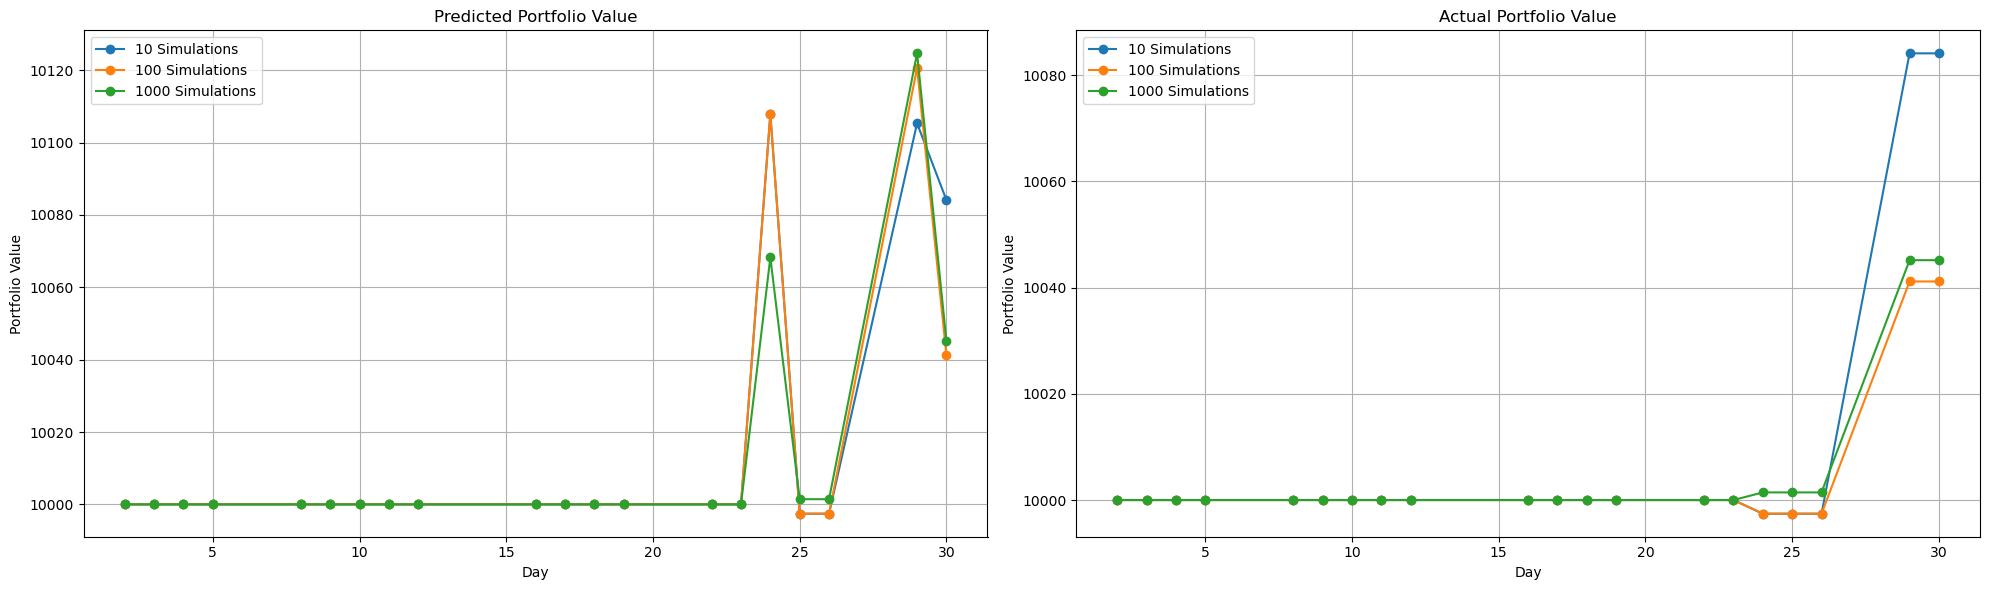

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

axes[0].plot(rf10_df['Day'], rf10_df['Predicted_profit'] + rf10_df['Portoflio_value_before_investment'], label='10 Simulations', marker='o')
axes[0].plot(rf100_df['Day'], rf100_df['Predicted_profit'] + rf100_df['Portoflio_value_before_investment'], label='100 Simulations', marker='o')
axes[0].plot(rf1000_df['Day'], rf1000_df['Predicted_profit'] + rf1000_df['Portoflio_value_before_investment'], label='1000 Simulations', marker='o')
axes[0].set_title('Predicted Portfolio Value')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Portfolio Value')
axes[0].legend()
axes[0].grid()

axes[1].plot(rf10_df['Day'], rf10_df['Portfolio_value_after_investment'], label='10 Simulations', marker='o')
axes[1].plot(rf100_df['Day'], rf100_df['Portfolio_value_after_investment'], label='100 Simulations', marker='o')
axes[1].plot(rf1000_df['Day'], rf1000_df['Portfolio_value_after_investment'], label='1000 Simulations', marker='o')
axes[1].set_title('Actual Portfolio Value')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Portfolio Value')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

As we can see, the predicted portfolio value **stays the same** for the first 22 days. This absence of change is the result of **integrating the RMSE in the calculation of valid stocks to buy**, as explained above.<br>
Since the RMSE value from Random Forest is about 38, a big part of the stocks are excluded immediatly, since to be considered valid the expected profit has to be bigger than 20 (half of the RMSE + value of transaction).

We can also conclude that the **predicted values are not far away from reality**, being similar to one another!

As for a relation between number of simulations per day and profit, little can be said, since the experiment with most profit was the one with 10 simulations/day, followed by the one with 1000 simulations/day, and finally 100 simulations/day.

In [18]:
for i in range(len(dataframes_rf)):
    
    temp_num_sims=nums_simulations[i]
    
    temp_dataframe = dataframes_rf[i]
    
    temp_dia_30 = temp_dataframe[temp_dataframe["Day"]==30]
    
    temp_valor_final = temp_dia_30["Portfolio_value_after_investment"].iloc[0]
    
    temp_balance = "Loss"
    if temp_valor_final>10000: temp_balance="Profit"
        
    temp_difference_amount = temp_valor_final-10000
    
    temp_max_value = temp_dataframe['Portfolio_value_after_investment'].max()
    temp_max_day = temp_dataframe.loc[temp_dataframe['Portfolio_value_after_investment'].idxmax(), 'Day']
    temp_max_value2 = temp_dataframe['Portoflio_value_before_investment'].max()
    temp_max_day2 = temp_dataframe.loc[temp_dataframe['Portoflio_value_before_investment'].idxmax(), 'Day']
    if temp_max_value2>temp_max_value:
        temp_max_value=temp_max_value2
        temp_max_day=temp_max_day2
        
    temp_min_value = temp_dataframe['Portfolio_value_after_investment'].min()
    temp_min_day = temp_dataframe.loc[temp_dataframe['Portfolio_value_after_investment'].idxmin(), 'Day']
    temp_min_value2 = temp_dataframe['Portoflio_value_before_investment'].min()
    temp_min_day2 = temp_dataframe.loc[temp_dataframe['Portoflio_value_before_investment'].idxmin(), 'Day']
    if temp_min_value2<temp_min_value:
        temp_min_value=temp_min_value2
        temp_min_day=temp_min_day2
    
    temp_cumulative_return = (temp_valor_final-10000)/100
    
    tabela_valores_rf.append({
        'Simulations_per_day': temp_num_sims,
        'Starting_portfolio_value': 10000,
        'Final_portfolio_value': temp_valor_final,
        'Profit_or_loss': temp_balance,
        'Difference_amount_from_start': temp_difference_amount,
        'Max_porfolio_value': temp_max_value,
        'Day_max_portfolio_value':temp_max_day,
        'Min_portfolio_value': temp_min_value,
        'Day_min_portfolio_value': temp_min_day,
        'Cumulative_return (%)': temp_cumulative_return
    })    
    

    
tabela_valores_rf = pd.DataFrame(tabela_valores_rf)
tabela_valores_rf = tabela_valores_rf.transpose()
tabela_valores_rf

,0,1,2
Simulations_per_day,10,100,1000
Starting_portfolio_value,10000,10000,10000
Final_portfolio_value,10084.121826,10041.160889,10045.170898
Profit_or_loss,Profit,Profit,Profit
Difference_amount_from_start,84.121826,41.160889,45.170898
Max_porfolio_value,10084.121826,10041.160889,10045.170898
Day_max_portfolio_value,29,29,29
Min_portfolio_value,9997.422852,9997.422852,10000.0
Day_min_portfolio_value,24,24,2
Cumulative_return (%),0.841218,0.411609,0.451709


As seen in the table above, the values from each experiment are really similar.

The **final portfolio value is always around 10040 USD and 10080 USD (always profiting)**. They all have a maximum value at day 29, and the day with the minimum value varies between experiment.

As a final metric we have the **cumulative return**, which is **0.85%** for the experiment with 10 simulations/day, **0.51%** for the experiment with 100 simulations/day, and **0.45%** for the experiment with 1000 experiments/day.

These results are not exceptionally good but, taking in account the difficulty of this task, and since we are always profitting, these values are still pleasant.

### 

### &emsp;&emsp; 4.2 MLP

In [19]:
# Load the results
file_paths_mlp = ["results/results_mlp10.pkl","results/results_mlp100.pkl", "results/results_mlp1000.pkl"]
dataframes_mlp = []

# Load each file into a DataFrame
for file_path_mlp in file_paths_mlp:
    with open(os.path.join(os.getcwd(), file_path_mlp), "rb") as ficheiro:
        data = pickle.load(ficheiro)
    dataframes_mlp.append(pd.DataFrame(data))
    
tabela_valores_mlp = []

mlp10_df = dataframes_mlp[0]
mlp100_df = dataframes_mlp[1]
mlp1000_df = dataframes_mlp[2]

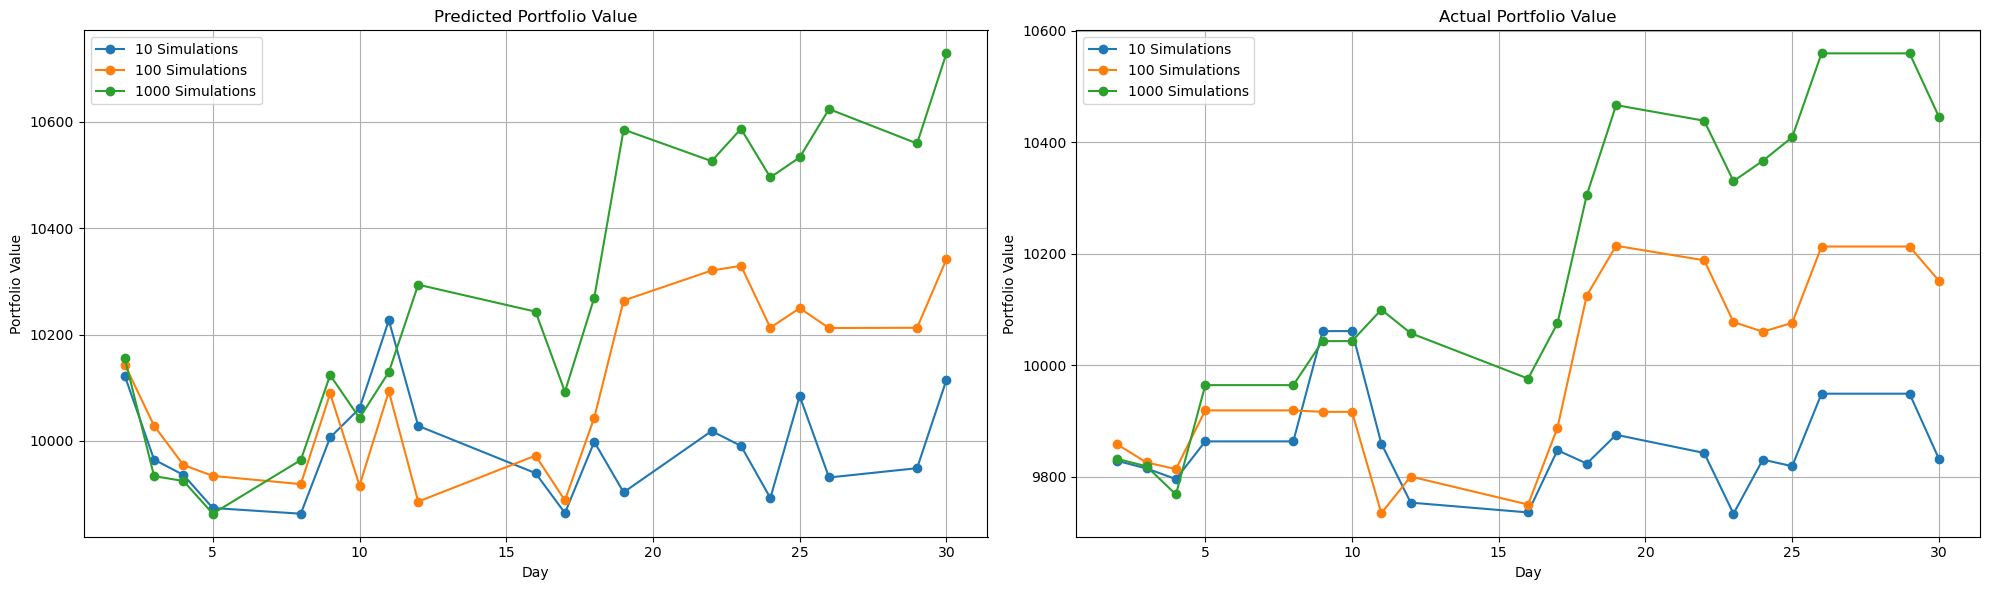

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

axes[0].plot(mlp10_df['Day'], mlp10_df['Predicted_profit'] + mlp10_df['Portoflio_value_before_investment'], label='10 Simulations', marker='o')
axes[0].plot(mlp100_df['Day'], mlp100_df['Predicted_profit'] + mlp100_df['Portoflio_value_before_investment'], label='100 Simulations', marker='o')
axes[0].plot(mlp1000_df['Day'], mlp1000_df['Predicted_profit'] + mlp1000_df['Portoflio_value_before_investment'], label='1000 Simulations', marker='o')
axes[0].set_title('Predicted Portfolio Value')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Portfolio Value')
axes[0].legend()
axes[0].grid()

axes[1].plot(mlp10_df['Day'], mlp10_df['Portfolio_value_after_investment'], label='10 Simulations', marker='o')
axes[1].plot(mlp100_df['Day'], mlp100_df['Portfolio_value_after_investment'], label='100 Simulations', marker='o')
axes[1].plot(mlp1000_df['Day'], mlp1000_df['Portfolio_value_after_investment'], label='1000 Simulations', marker='o')
axes[1].set_title('Actual Portfolio Value')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Portfolio Value')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

Now for the MLP, we see a really **drastic change in these graphics**.

At first sight, we can immediatly tell the **number of simulations/day play a big role in this model**.<br>
On the left, we can see **similarly growing graphics**, with almost equal patterns, but changing in value. The graph which promisses more profit is the one with 10000 simulations/day, the second is the one with 100 simulations/day, and finally the one with 10 simulations/day.

On the right, the exact same thing happens!<br>
This **similarity in graphics** can help us conclude that this model is a good choice to use with Monte Carlo, since our predictions were on point!

In [21]:
for i in range(len(dataframes_mlp)):
    
    temp_num_sims=nums_simulations[i]
    
    temp_dataframe = dataframes_mlp[i]
    
    temp_dia_30 = temp_dataframe[temp_dataframe["Day"]==30]
    
    temp_valor_final = temp_dia_30["Portfolio_value_after_investment"].iloc[0]
    
    temp_balance = "Loss"
    if temp_valor_final>10000: temp_balance="Profit"
        
    temp_difference_amount = temp_valor_final-10000
    
    temp_max_value = temp_dataframe['Portfolio_value_after_investment'].max()
    temp_max_day = temp_dataframe.loc[temp_dataframe['Portfolio_value_after_investment'].idxmax(), 'Day']
    temp_max_value2 = temp_dataframe['Portoflio_value_before_investment'].max()
    temp_max_day2 = temp_dataframe.loc[temp_dataframe['Portoflio_value_before_investment'].idxmax(), 'Day']
    if temp_max_value2>temp_max_value:
        temp_max_value=temp_max_value2
        temp_max_day=temp_max_day2
        
    temp_min_value = temp_dataframe['Portfolio_value_after_investment'].min()
    temp_min_day = temp_dataframe.loc[temp_dataframe['Portfolio_value_after_investment'].idxmin(), 'Day']
    temp_min_value2 = temp_dataframe['Portoflio_value_before_investment'].min()
    temp_min_day2 = temp_dataframe.loc[temp_dataframe['Portoflio_value_before_investment'].idxmin(), 'Day']
    if temp_min_value2<temp_min_value:
        temp_min_value=temp_min_value2
        temp_min_day=temp_min_day2
        
    temp_cumulative_return = (temp_valor_final-10000)/100
    
    
    tabela_valores_mlp.append({
        'Simulations_per_day': temp_num_sims,
        'Starting_portfolio_value': 10000,
        'Final_portfolio_value': temp_valor_final,
        'Profit_or_loss': temp_balance,
        'Difference_amount_from_start': temp_difference_amount,
        'Max_porfolio_value': temp_max_value,
        'Day_max_portfolio_value':temp_max_day,
        'Min_portfolio_value': temp_min_value,
        'Day_min_portfolio_value': temp_min_day,
        'Cumulative_return (%)': temp_cumulative_return
    })    

tabela_valores_mlp = pd.DataFrame(tabela_valores_mlp)
tabela_valores_mlp = tabela_valores_mlp.transpose()
tabela_valores_mlp

,0,1,2
Simulations_per_day,10,100,1000
Starting_portfolio_value,10000,10000,10000
Final_portfolio_value,9831.697411,10151.348186,10445.729103
Profit_or_loss,Loss,Profit,Profit
Difference_amount_from_start,-168.302589,151.348186,445.729103
Max_porfolio_value,10061.016785,10214.168625,10559.579964
Day_max_portfolio_value,9,19,26
Min_portfolio_value,9733.245529,9734.320114,9767.747498
Day_min_portfolio_value,23,11,4
Cumulative_return (%),-1.683026,1.513482,4.457291


Finally, we have the table for MLP.<br>
As we can see, values differ a lot. For the experiment with **10 simulations/day**, we have an **unpleasant surprise**! We **lost almost 170 USD**.<br>
Fortunately, this was a single event! We then profitted on the remaining 2 experiments (a lot more than when using RF).

We achieved a **cumulative return** of **4.45%** on the experiment with 1000 simulations/day! This is and amazing result!

# 

# 5. Conclusion and Final Comments

As we could see, **results varied** (A LOT).<br>
We saw a more **"shy" approach when using Random Forest**, due to the **high RMSE** value, which returned little profits.<br>
On the other hand, we saw a more **"aggressive" approach when using MLP**, in part due to the **smaller RMSE** value, which returned more volatile (yet bigger) results!

We were very happy with all our results, and wanted to see the final result using 10000 simulations/day for MLP, but the amount of time it took (3 days and still not over) made it impossible to do so :(

This is a very complex topic, and if the given needed time, the **work would be endless...**

We could have added more complex features to our dataset, like:
- sector of the stocks, allowing for diversification on our portfolio;
- mention of certain sectors/companies in recent news;
- ...

---

We could have made a different type of prediction model:
- predict a different variable;
- predict a couple days/weeks ahead;
- predict open/high/lows;
- ...

---

We could have optimized our portfolio differently, like:
- different prediction model (Linear Regression, XGBoost, LSTM, ...);
- different algorithm choice (MinMax, Genetic, ...);
- different "score" formulas;
- ...

To conclude, the time/expertise limitations made for a non-optimal work, but still good enough to profit almost always!<br>
Since we are not stock analystis, this sufficed as an experiment, and we are very happy with our work :3